In [23]:
import os

import pandas as pd
import pandas_datareader.data as pdr # pip install pandas_datareader

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use("seaborn-whitegrid")

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import seaborn as sns
plt.style.use("seaborn-whitegrid")

%matplotlib inline
import itertools

In [24]:
data = pd.read_csv("AirPassengers.csv")
data = data.rename(columns={"Month": "month", "#Passengers":'passengers'})
data['month'] = pd.to_datetime(data['month'])
data = data.set_index('month')
data.head()

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


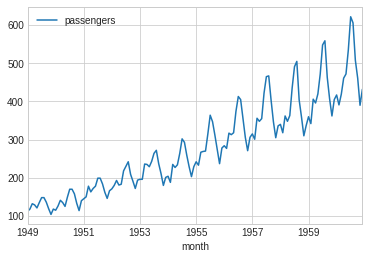

In [25]:
fig = data.plot()

In [26]:
# import statsmodels.tsa.api as tsa
# decomposition = tsa.seasonal_decompose(data['passengers'], model='additive', period=1)

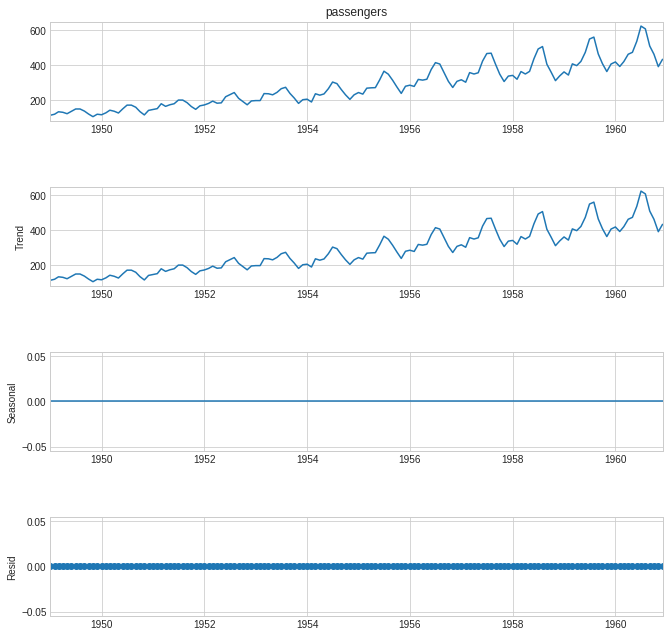

In [27]:
decomposition = sm.tsa.seasonal_decompose(data['passengers'], model='additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.show()

In [28]:
train_data, test_data =  train_test_split(data, test_size=0.2, shuffle=False)

# 정상성 판단

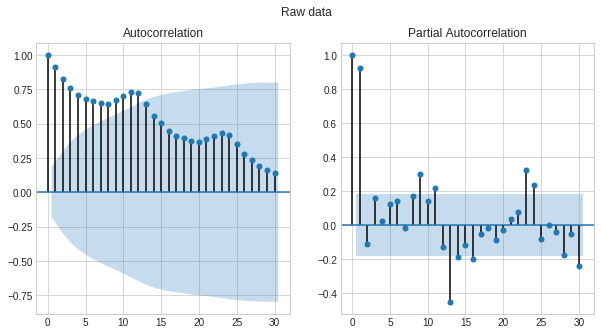

In [29]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
fig.suptitle('Raw data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1]);

# 정상성 판단2 (단위근 검정)
- 단위근: 확률론 데이터 검정에서 쓰이는 개념으로 시계열 데이터는 시간에 따라 일정한 규칙을 가짐
- AR이 포함된 모형과 연관이 있다.
- Augmented Dickey-Fuller test
    - 귀무가설: 자료에 단위근이 존재한다. (안정적이지 않다.)
    - 대립가설: 시계열 자료가 정상성을 만족한다. p-value < 0.05

In [30]:
from statsmodels.tsa.stattools import adfuller

In [33]:
result = adfuller(train_data['passengers'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.356889
p-value: 0.917052
Critical Test Statistics Values:
	1%: -3.497
	5%: -2.891
	10%: -2.582


### 결과해석
- p-value > 0.05 이므로 귀무가설 채택. 즉, 데이터는 정상성을 만족하지 않는다.

# 차분
- 데이터가 정상성을 띄지 않으므로 정상성을 같도록 차분을 진행해야함

In [34]:
diff_train_data = train_data.copy()
diff_train_data = diff_train_data['passengers'].diff()

# 차분을 하면 마지막 값은 값이 없으므로 결측치 처리를 해야함
diff_train_data = diff_train_data.dropna()

In [35]:
train_data

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1958-03-01,362
1958-04-01,348
1958-05-01,363


In [36]:
diff_train_data

month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1958-03-01    44.0
1958-04-01   -14.0
1958-05-01    15.0
1958-06-01    72.0
1958-07-01    56.0
Name: passengers, Length: 114, dtype: float64

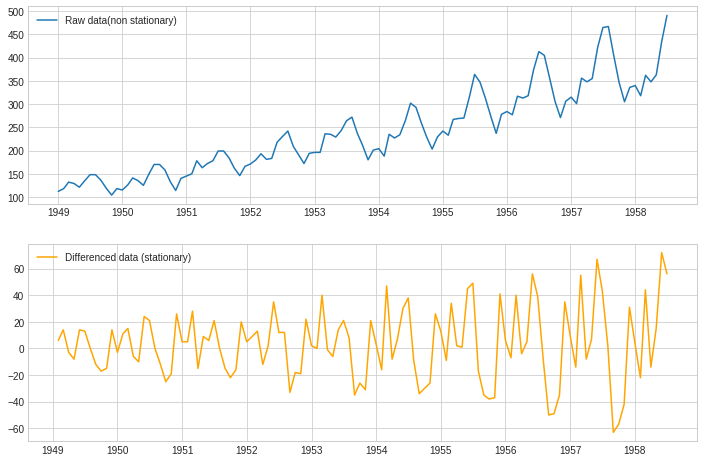

In [37]:
plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(train_data['passengers'])
plt.legend(["Raw data(non stationary)"])

plt.subplot(212)
plt.plot(diff_train_data, 'orange')
plt.legend(['Differenced data (stationary)'])
plt.show()

/home/jmhwang/miniconda3/envs/adp/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


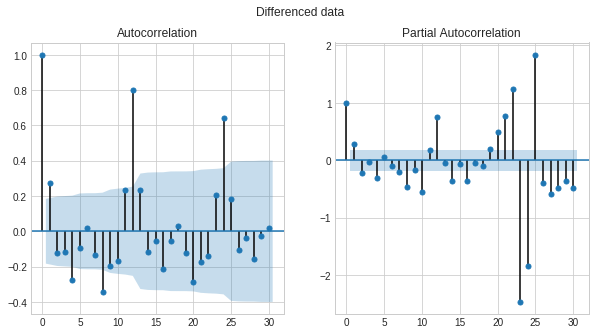

In [38]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
fig.suptitle('Differenced data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1]);

# 판단기준 추가할것

# 임의의 계수와 차분으로 모델링

In [13]:
model = ARIMA(train_data.values, order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  114
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -531.720
Method:                       css-mle   S.D. of innovations             25.659
Date:                Sat, 12 Mar 2022   AIC                           1069.440
Time:                        20:37:05   BIC                           1077.649
Sample:                             1   HQIC                          1072.771
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5123      3.329      1.055      0.291      -3.012      10.036
ar.L1.D.y      0.2803      0.091      3.077      0.002       0.102       0.459
                                    Roots           

# 정확히 파라미터 뽑아보기

In [14]:
# p = range(0, 3)
# d = range(1, 2)
# q = range(0, 3)
# pdq = list(itertools.product(p, d, q))

# aic = []
# for i in pdq:
#     model = ARIMA(train_data.values, order=(i))
#     model_fit = model.fit()
#     print(f'ARIAM:{i} >> AIC: {round(model_fit.aic, 2)}')
#     aic.append(round(model_fit.aic, 2))

ARIAM:(0, 1, 0) >> AIC: 1076.52
ARIAM:(0, 1, 1) >> AIC: 1064.62
ARIAM:(0, 1, 2) >> AIC: 1061.08
ARIAM:(1, 1, 0) >> AIC: 1069.44
ARIAM:(1, 1, 1) >> AIC: 1058.83
ARIAM:(1, 1, 2) >> AIC: 1046.05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66421D+00    |proj g|=  1.22906D-03

At iterate    5    f=  4.66421D+00    |proj g|=  1.11999D-04

At iterate   10    f=  4.66421D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     14      1     0   

ARIAM:(2, 1, 1) >> AIC: 1045.66
ARIAM:(2, 1, 2) >> AIC: 1047.19


# 최종 선정된 파라미터

In [15]:
optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[((2, 1, 1), 1045.66)]

In [16]:
model_opt = ARIMA(train_data.values, order=optimal[0][0])
model_opt_fit = model_opt.fit()
print(model_opt_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  114
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -517.830
Method:                       css-mle   S.D. of innovations             22.316
Date:                Sat, 12 Mar 2022   AIC                           1045.660
Time:                        20:37:05   BIC                           1059.341
Sample:                             1   HQIC                          1051.212
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5600      0.162     15.754      0.000       2.241       2.878
ar.L1.D.y      1.0890      0.085     12.816      0.000       0.922       1.256
ar.L2.D.y     -0.4730      0.086     -5.528      0.0

In [18]:
prediction = model_opt_fit.forecast(len(test_data))
predicted_value = prediction[0]
predicted_ub = prediction[2][:, 0]
predicted_lb = prediction[2][:, 1]
predicted_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

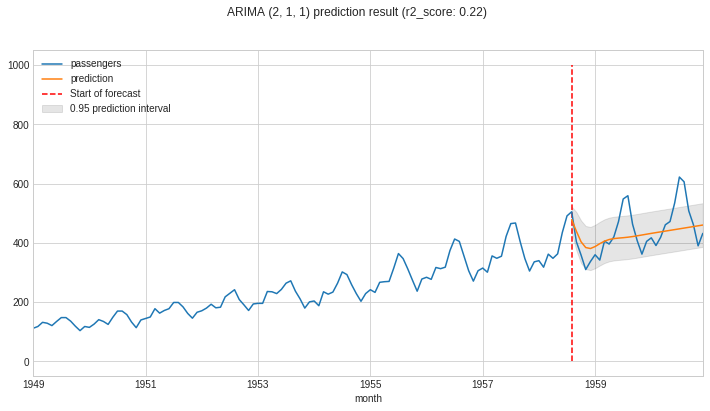

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(ax=ax);

# test data 시작점 -> "1958-08-01"
ax.vlines(str(test_data.iloc[0].name), 0, 1000, linestyle='--', color='r', label='Start of forecast');
ax.plot(predicted_index, predicted_value, label="prediction")
ax.fill_between(predicted_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label="0.95 prediction interval")
ax.legend(loc='upper left')

plt.suptitle(f'ARIMA {optimal[0][0]} prediction result (r2_score: {round(r2, 2)})')
plt.show()

# SARIMA

In [20]:
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [21]:
aic = []
params = []
for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train_data.values, order=(i), seasonal_order=(j))
            model_fit = model.fit()
            print(f'SARIMA:{i} >> AIC: {round(model_fit.aic, 2)}')
            aic.append(round(model_fit.aic, 2))
            params.append((i, j))
        except:
            continue

SARIMA:(0, 1, 0) >> AIC: 757.83
SARIMA:(0, 1, 0) >> AIC: 756.99
SARIMA:(0, 1, 0) >> AIC: 758.83
    3      9     14      1     0     0   1.776D-07   4.641D+00
  F =   4.6412394148344882     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 Cauchy                time 0.000E+00 seconds.
 Subspace minimization time 0.000E+00 seconds.
 Line search           time 0.000E+00 seconds.

 Total User time 0.000E+00 seconds.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.55030D+00    |proj g|=  1.20957D-02

At iterate    5    f=  4.54353D+00    |proj g|=  3.62181D-03

At iterate   10    f=  4.54239D+00    |proj g|=  2.88214D-04

At iterate   15    f=  4.54237D+00    |proj g|=  6.53699D-05

At iterate   20    f=  4.54237D+00    |proj g|=  4.88498D-06

At iterate   25    f=  4.54237D+00    |proj g|=  7.99361D-07

           * * *

Tit   = t

SARIMA:(0, 1, 0) >> AIC: 758.92
SARIMA:(0, 1, 0) >> AIC: 754.42
SARIMA:(0, 1, 0) >> AIC: 758.87
SARIMA:(0, 1, 0) >> AIC: 760.73


/home/jmhwang/miniconda3/envs/adp/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA:(0, 1, 0) >> AIC: 754.9
SARIMA:(0, 1, 1) >> AIC: 756.01
   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     10      1     0     0   1.719D-06   3.274D+00
  F =   3.2737354957245000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

 Cauchy                time 0.000E+00 seconds.
 Subspace minimization time 0.000E+00 seconds.
 Line search           time 0.000E+00 seconds.

 Total User time 0.000E+00 seconds.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27538D+00    |proj g|=  3.09739D-02

At iterate    5    f=  3.27403D+00    |proj g|=  2.01981D-02

At iterate   10    f=  3.27360D+00    |proj g|=  3.26717D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS up

SARIMA:(0, 1, 1) >> AIC: 756.38
SARIMA:(0, 1, 1) >> AIC: 757.65
SARIMA:(0, 1, 1) >> AIC: 756.17
SARIMA:(0, 1, 1) >> AIC: 758.11


/home/jmhwang/miniconda3/envs/adp/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA:(0, 1, 1) >> AIC: 751.73
SARIMA:(0, 1, 1) >> AIC: 757.99
SARIMA:(0, 1, 1) >> AIC: 753.78
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   6.363D-06   3.263D+00
  F =   3.2625229644047171     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

 Cauchy                time 0.000E+00 seconds.
 Subspace minimization time 0.000E+00 seconds.
 Line search           time 0.000E+00 seconds.

 Total User time 0.000E+00 seconds.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51240D+00    |proj g|=  2.92669D-01

At iterate    5 

/home/jmhwang/miniconda3/envs/adp/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA:(0, 1, 1) >> AIC: 760.22
SARIMA:(0, 1, 2) >> AIC: 757.78
SARIMA:(0, 1, 2) >> AIC: 758.04
SARIMA:(0, 1, 2) >> AIC: 759.28
SARIMA:(0, 1, 2) >> AIC: 757.81
SARIMA:(0, 1, 2) >> AIC: 759.75
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46597D+00    |proj g|=  4.11139D-01

At iterate    5    f=  3.27482D+00    |proj g|=  3.17061D-02

At iterate   10    f=  3.26456D+00    |proj g|=  9.26376D-03

At iterate   15    f=  3.26163D+00    |proj g|=  7.03379D-03

At iterate   20    f=  3.25450D+00    |proj g|=  2.80106D-02

At iterate   25    f=  3.25321D+00    |proj g|=  5.26981D-03

At iterate   30    f=  3.25315D+00    |proj g|=  6.01384D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact

SARIMA:(0, 1, 2) >> AIC: 759.64
SARIMA:(0, 1, 2) >> AIC: 755.49
SARIMA:(0, 1, 2) >> AIC: 761.99
SARIMA:(1, 1, 0) >> AIC: 755.5
SARIMA:(1, 1, 0) >> AIC: 755.98
SARIMA:(1, 1, 0) >> AIC: 757.1
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 Cauchy                time 0.000E+00 seconds.
 Subspace minimization time 0.000E+00 seconds.
 Line search           time 0.000E+00 seconds.

 Total User time 0.000E+00 seconds.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26626D+00    |proj g|=  7.47640D-02

At iterate    5    f=  3.25983D+00    |proj g|=  9.27901D-03

At iterate   10    f=  3.25931D+00    |proj g|=  2.71970D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = numbe

SARIMA:(1, 1, 0) >> AIC: 757.65
SARIMA:(1, 1, 0) >> AIC: 751.15
SARIMA:(1, 1, 0) >> AIC: 757.45
SARIMA:(1, 1, 0) >> AIC: 752.99


/home/jmhwang/miniconda3/envs/adp/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA:(1, 1, 0) >> AIC: 759.88
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   5.596D-07   3.260D+00
  F =   3.2597837869743120     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

 Cauchy                time 0.000E+00 seconds.
 Subspace minimization time 0.000E+00 seconds.
 Line search           time 0.000E+00 seconds.

 Total User time 0.000E+00 seconds.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26246D+00    |proj g|=  2.94278D-02

At iterate    5    f=  3.26050D+00    |proj g|=  2.32979D-02

At iterate   10    f=  3.25934D+00    |proj g|=  6.87139D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = 

SARIMA:(1, 1, 1) >> AIC: 756.63
SARIMA:(1, 1, 1) >> AIC: 757.75
SARIMA:(1, 1, 1) >> AIC: 756.41
SARIMA:(1, 1, 1) >> AIC: 758.26


/home/jmhwang/miniconda3/envs/adp/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA:(1, 1, 1) >> AIC: 752.53
SARIMA:(1, 1, 1) >> AIC: 758.03
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

 Cauchy                time 0.000E+00 seconds.
 Subspace minimization time 0.000E+00 seconds.
 Line search           time 0.000E+00 seconds.

 Total User time 0.000E+00 seconds.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26183D+00    |proj g|=  2.06734D-02

At iterate    5    f=  3.25600D+00    |proj g|=  2.38286D-02

At iterate   10    f=  3.25491D+00    |proj g|=  3.47609D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

SARIMA:(1, 1, 1) >> AIC: 754.16
SARIMA:(1, 1, 1) >> AIC: 760.18
SARIMA:(1, 1, 2) >> AIC: 757.92
SARIMA:(1, 1, 2) >> AIC: 758.44
SARIMA:(1, 1, 2) >> AIC: 759.63
SARIMA:(1, 1, 2) >> AIC: 758.22
At iterate   30    f=  3.22684D+00    |proj g|=  7.36753D-04

At iterate   35    f=  3.22680D+00    |proj g|=  8.28684D-04

At iterate   40    f=  3.22679D+00    |proj g|=  4.87183D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     60      1     0     0   2.493D-04   3.227D+00
  F =   3.2267921438846359     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 Cauchy                time 0.000E+00 seconds

/home/jmhwang/miniconda3/envs/adp/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA:(1, 1, 2) >> AIC: 754.53
SARIMA:(1, 1, 2) >> AIC: 759.92


/home/jmhwang/miniconda3/envs/adp/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA:(1, 1, 2) >> AIC: 756.16


/home/jmhwang/miniconda3/envs/adp/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA:(1, 1, 2) >> AIC: 762.42
SARIMA:(2, 1, 0) >> AIC: 756.77
 Subspace minimization time 0.000E+00 seconds.
 Line search           time 0.000E+00 seconds.

 Total User time 0.000E+00 seconds.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46995D+00    |proj g|=  2.93684D-01

At iterate    5    f=  3.29178D+00    |proj g|=  5.33611D-02

At iterate   10    f=  3.23060D+00    |proj g|=  3.39467D-02

At iterate   15    f=  3.22152D+00    |proj g|=  1.47984D-02

At iterate   20    f=  3.21991D+00    |proj g|=  6.22147D-03

At iterate   25    f=  3.21984D+00    |proj g|=  1.34007D-04

At iterate   30    f=  3.21982D+00    |proj g|=  2.71401D-03

At iterate   35    f=  3.21974D+00    |proj g|=  1.03864D-03

At iterate   40    f=  3.21971D+00    |proj g|=  9.73615D-04

At iterate   45    f=  3.21971D+00    |proj g|=  3.13439D-04

At iterate   50 

SARIMA:(2, 1, 0) >> AIC: 758.31
SARIMA:(2, 1, 0) >> AIC: 756.98
SARIMA:(2, 1, 0) >> AIC: 758.86
SARIMA:(2, 1, 0) >> AIC: 752.77
SARIMA:(2, 1, 0) >> AIC: 758.65
SARIMA:(2, 1, 0) >> AIC: 754.51


/home/jmhwang/miniconda3/envs/adp/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jmhwang/miniconda3/envs/adp/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 Subspace minimization time 0.000E+00 seconds.
 Line search           time 0.000E+00 seconds.

 Total User time 0.000E+00 seconds.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52314D+00    |proj g|=  2.77170D-01

At iterate    5    f=  3.46522D+00    |proj g|=  4.14078D-02

At iterate   10    f=  3.28375D+00    |proj g|=  4.89562D-02

At iterate   15    f=  3.25354D+00    |proj g|=  1.81698D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0 

SARIMA:(2, 1, 1) >> AIC: 758.54
SARIMA:(2, 1, 1) >> AIC: 759.69
SARIMA:(2, 1, 1) >> AIC: 758.31
SARIMA:(2, 1, 1) >> AIC: 760.18


/home/jmhwang/miniconda3/envs/adp/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA:(2, 1, 1) >> AIC: 754.54
At iterate    0    f=  3.28669D+00    |proj g|=  1.88405D-01

At iterate    5    f=  3.26499D+00    |proj g|=  1.72099D-02

At iterate   10    f=  3.26079D+00    |proj g|=  1.89329D-03

At iterate   15    f=  3.26076D+00    |proj g|=  5.04005D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     18      1     0     0   7.268D-06   3.261D+00
  F =   3.2607639143988667     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

 Cauchy                time 0.000E+00 seconds.
 Subspace minimization time 0.000E+00 seconds.
 Line search           time 0.000E+00 seconds.

 

SARIMA:(2, 1, 1) >> AIC: 756.16
SARIMA:(2, 1, 2) >> AIC: 755.2
SARIMA:(2, 1, 2) >> AIC: 755.99
SARIMA:(2, 1, 2) >> AIC: 759.77
SARIMA:(2, 1, 2) >> AIC: 755.82
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     23      1     0     0   6.540D-06   3.252D+00
  F =   3.2520699190115629     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

 Cauchy                time 0.000E+00 seconds.
 Subspace minimization time 0.000E+00 seconds.
 Line search           time 0.000E+00 seconds.

 Total User time 0.000E+00 seconds.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27520D+00    |proj g|=  1.48620D-01

At iterate    5   

SARIMA:(2, 1, 2) >> AIC: 757.71
SARIMA:(2, 1, 2) >> AIC: 752.34
SARIMA:(2, 1, 2) >> AIC: 757.56
SARIMA:(2, 1, 2) >> AIC: 753.95


In [22]:
optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[(((1, 1, 0), (1, 1, 2, 12)), 751.15)]

In [23]:
model_opt = SARIMAX(train_data.values, order=optimal[0][0][0], seasonal_order=optimal[0][0][1])
model_opt_fit = model_opt.fit()
print(model_opt_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -370.574
Date:                                 Sat, 12 Mar 2022   AIC                            751.148
Time:                                         20:40:15   BIC                            764.273
Sample:                                              0   HQIC                           756.463
                                                 - 115                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2362      0.093     -2.546      0.011      -0.418      -0

In [25]:
# arima와 조금 다름
prediction = model_opt_fit.get_forecast(len(test_data))
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int()[:,0]
predicted_lb = prediction.conf_int()[:,1]
predicted_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

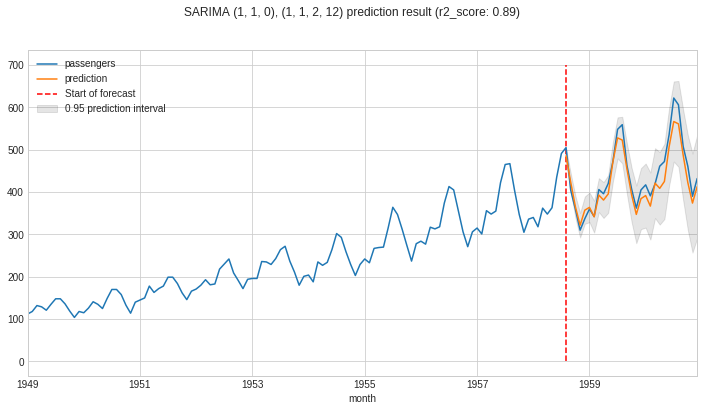

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(ax=ax);

# test data 시작점 -> "1958-08-01"
ax.vlines(str(test_data.iloc[0].name), 0, 700, linestyle='--', color='r', label='Start of forecast');
ax.plot(predicted_index, predicted_value, label="prediction")
ax.fill_between(predicted_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label="0.95 prediction interval")
ax.legend(loc='upper left')

plt.suptitle(f'SARIMA {optimal[0][0][0]}, {optimal[0][0][1]} prediction result (r2_score: {round(r2, 2)})')
plt.show()

# try~exceptioin을 해결한 유용한 패키지

In [39]:
from pmdarima.arima import auto_arima # pip install pmdarima

In [40]:
# auto_arima??

In [41]:
auto_arima_model = auto_arima(train_data, 
                              start_p=1,
                              start_q=1,
                              max_p=3,
                              max_q=3,
                              m=12,
                              seasonal=True,
                              d=1,
                              D=1,
                              max_P=3, max_Q=3,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=False,
                              n_jobs=-1
                             )


Best model:  ARIMA(1,1,0)(1,1,3)[12]          
Total fit time: 18.769 seconds


In [42]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -370.278
Date:                                    Sat, 12 Mar 2022   AIC                            752.557
Time:                                            22:20:16   BIC                            768.307
Sample:                                                 0   HQIC                           758.934
                                                    - 115                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2218      0.093     -2.388      0.017      -0.404      -0.040
ar.S.L12       0.9288      0.275      3.374      0.001       0.389       1.468
ma.S.L12      -1.2065      0.448     -2.692      0.007      -2.085      -0.328
ma.S.L24       0.2771      0.174      1.596      0.111      -0.063       0.618
ma.S.L36       0.1251      0.164      0.765      0.444      -0.195       0.446
sigma2        75.0386     19.073      3.934      0.000      37.656     112.421
===================================================================================
Ljung-Box (Q):                       40.92   Jarque-Bera (JB):                 2.50
Prob(Q):                              0.43   Prob(JB):                         0.29
Heteroskedasticity (H):               1.05   Skew:                             0.37
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# auto arima 사용한 예측 및 결과

In [43]:
# auto arima를 이용한 예측
prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predicted_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

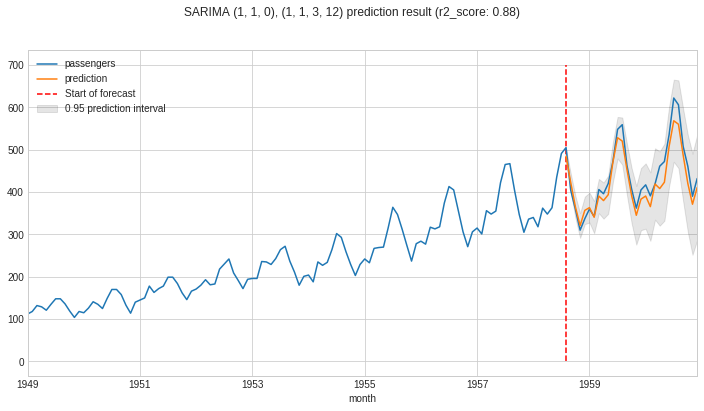

In [47]:
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(ax=ax);

# test data 시작점 -> "1958-08-01"
ax.vlines(str(test_data.iloc[0].name), 0, 700, linestyle='--', color='r', label='Start of forecast');
ax.plot(predicted_index, predicted_value, label="prediction")
ax.fill_between(predicted_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label="0.95 prediction interval")
ax.legend(loc='upper left')

plt.suptitle(f'SARIMA {auto_arima_model.order}, {auto_arima_model.seasonal_order} prediction result (r2_score: {round(r2, 2)})')
plt.show()

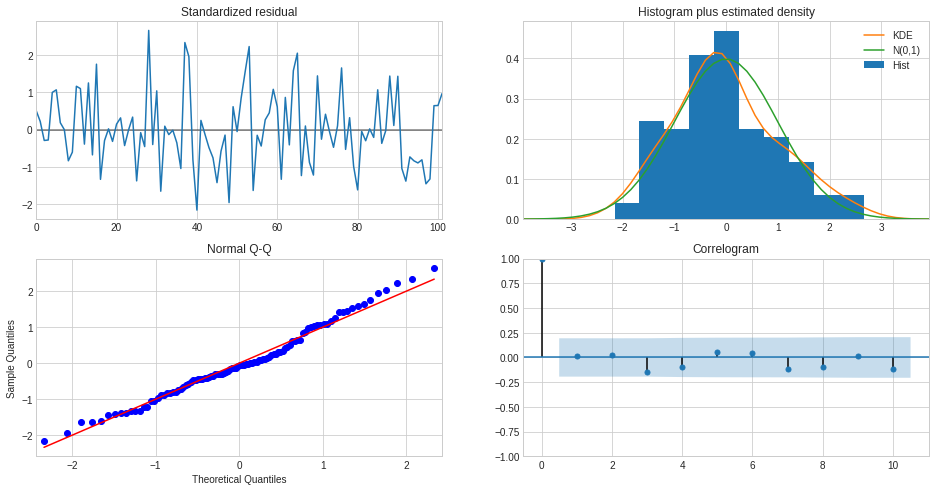

 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=2.45 sec
 ARIMA(0,1,1)(3,1,1)[12]             : AIC=inf, Time=8.20 sec
 ARIMA(1,1,3)(0,1,0)[12]             : AIC=754.178, Time=0.21 sec
 ARIMA(1,1,3)(1,1,0)[12]             : AIC=753.975, Time=0.99 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=758.903, Time=1.38 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=755.605, Time=0.06 sec
 ARIMA(3,1,0)(0,1,1)[12]             : AIC=756.424, Time=0.31 sec
 ARIMA(3,1,1)(0,1,0)[12]             : AIC=754.435, Time=0.25 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=754.685, Time=4.75 sec
 ARIMA(0,1,2)(2,1,1)[12]             : AIC=inf, Time=4.75 sec
 ARIMA(1,1,1)(3,1,0)[12]             : AIC=758.462, Time=2.07 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=758.650, Time=0.52 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=758.314, Time=0.31 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=755.201, Time=0.28 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=755.821, Time=0.97 sec
 ARIMA(0,1,0)(2,1,2)[1

In [54]:
# plt.figure(figsize=(12, 8))
auto_arima_model.plot_diagnostics(figsize=(16, 8));
plt.show()